# Практическое руководство по метрикам ROC-AUC, PR-AUC и R-squared

## Цель занятия

На этом занятии мы изучим три важные метрики оценки моделей машинного обучения:
1. **ROC-AUC** - для оценки качества бинарной классификации
2. **PR-AUC** - для оценки классификации при дисбалансе классов  
3. **R-squared** - для оценки качества регрессии


## Импорт необходимых библиотек

In [6]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    r2_score, mean_squared_error, classification_report, confusion_matrix
)

In [7]:
# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. ROC-AUC: Анализ качества бинарной классификации

In [8]:
# Загружаем датасет рака груди (классическая задача бинарной классификации)
cancer_data = load_breast_cancer()
X_cancer = cancer_data.data
y_cancer = cancer_data.target

print(f"Размер датасета: {X_cancer.shape}")
print(f"Классы: {cancer_data.target_names}")
print(f"Распределение классов: {np.bincount(y_cancer)}")

Размер датасета: (569, 30)
Классы: ['malignant' 'benign']
Распределение классов: [212 357]


In [9]:
# Разделяем данные на обучающую и тестовую выборки
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.3, random_state=42, stratify=y_cancer
)

In [10]:
# Логистическая регрессия
lr_model = LogisticRegression(random_state=42, max_iter=10000)
lr_model.fit(X_train_cancer, y_train_cancer)

# Случайный лес
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_cancer, y_train_cancer)

RandomForestClassifier(random_state=42)

ROC-AUC для логистической регрессии: 0.989
ROC-AUC для случайного леса: 0.991


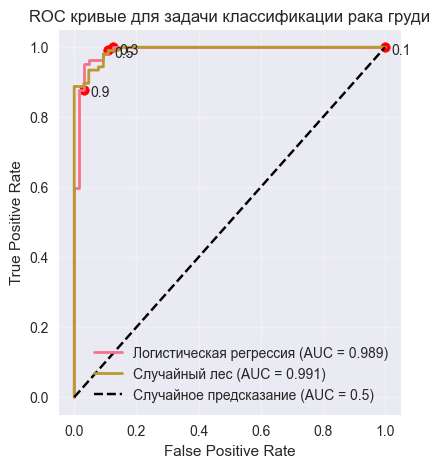

In [11]:
# Получаем вероятности предсказаний (нужны для построения ROC-кривой, т.к. ROC анализирует качество ранжирования по порогу)
# predict_proba(X) возвращает массив формы (n_samples, n_classes) с вероятностями по каждому классу.
# [:, 1] — берём вероятность "положительного" класса (класс с индексом 1). Для бинарной задачи это важно: ROC строится именно по score положительного класса.
lr_proba = lr_model.predict_proba(X_test_cancer)[:, 1]
rf_proba = rf_model.predict_proba(X_test_cancer)[:, 1]

# Вычисляем ROC кривые
# roc_curve(y_true, y_score) возвращает:
#  - fpr (False Positive Rate) — доля ложно-положительных среди всех отрицательных,
#  - tpr (True Positive Rate, чувствительность/Recall) — доля истинно-положительных среди всех положительных,
#  - thresholds — список порогов, при "сдвиге" которых считаются пары (fpr, tpr).
# Важно: thresholds отсортированы по убыванию score; при пороге → -∞ все объекты положительные (TPR=1, FPR=1), при пороге → +∞ все отрицательные (TPR=0, FPR=0).
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test_cancer, lr_proba)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test_cancer, rf_proba)

# Вычисляем площадь под ROC-кривой (AUC).
lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)

# Строим ROC-кривые для сравнения двух моделей.
plt.figure(figsize=(15, 5))

# Первый подграфик (из трёх): сами кривые и диагональная линия случайного классификатора.
plt.subplot(1, 3, 1)

# Линии ROC для логистической регрессии и случайного леса; в легенде показываем AUC с округлением до тысячных.
plt.plot(lr_fpr, lr_tpr, label=f'Логистическая регрессия (AUC = {lr_auc:.3f})', linewidth=2)
plt.plot(rf_fpr, rf_tpr, label=f'Случайный лес (AUC = {rf_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Случайное предсказание (AUC = 0.5)')

# Для наглядности отметим на ROC логистической регрессии несколько характерных порогов вероятности.
for thresh in [0.9, 0.5, 0.3, 0.1]:
    # Находим индекс ближайшего порога
    idx = np.argmin(np.abs(lr_thresholds - thresh))
    plt.scatter(lr_fpr[idx], lr_tpr[idx], marker='o', color='red')
    plt.text(lr_fpr[idx]+0.02, lr_tpr[idx]-0.02, f'{thresh:.1f}', fontsize=10)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые для задачи классификации рака груди')
plt.legend()
plt.grid(True, alpha=0.3)

print(f"ROC-AUC для логистической регрессии: {lr_auc:.3f}")
print(f"ROC-AUC для случайного леса: {rf_auc:.3f}")

## 2. PR-AUC: Анализ качества для несбалансированных данных

In [12]:
# Создаем несбалансированный датасет для демонстрации
X_imbalanced, y_imbalanced = make_classification(
    n_samples=1000, n_features=20, n_informative=10, n_redundant=10,
    n_clusters_per_class=1, weights=[0.9, 0.1], random_state=42
)

print(f"Распределение классов в несбалансированном датасете: {np.bincount(y_imbalanced)}")
print(f"Процент положительных примеров: {y_imbalanced.mean():.1%}")

Распределение классов в несбалансированном датасете: [896 104]
Процент положительных примеров: 10.4%


In [13]:
# Разделяем данные
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.3, random_state=42, stratify=y_imbalanced
)

In [14]:
# Обучаем модели
lr_imb = LogisticRegression(random_state=42)
lr_imb.fit(X_train_imb, y_train_imb)

rf_imb = RandomForestClassifier(n_estimators=100, random_state=42)
rf_imb.fit(X_train_imb, y_train_imb)

RandomForestClassifier(random_state=42)

PR-AUC для логистической регрессии: 0.967
PR-AUC для случайного леса: 0.973
Базовая линия PR-AUC: 0.103


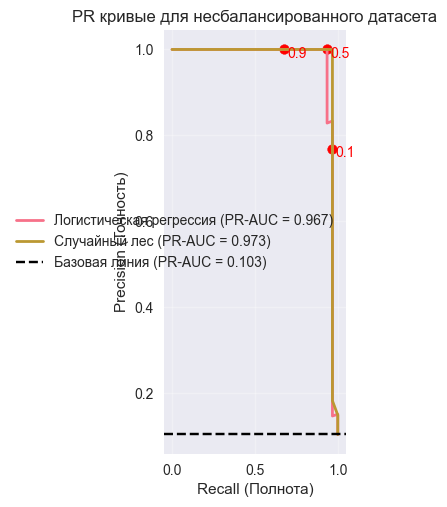

In [15]:
# Получаем вероятности
lr_imb_proba = lr_imb.predict_proba(X_test_imb)[:, 1]
rf_imb_proba = rf_imb.predict_proba(X_test_imb)[:, 1]

# Вычисляем PR кривые
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_test_imb, lr_imb_proba)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test_imb, rf_imb_proba)

# Вычисляем PR-AUC
lr_pr_auc = average_precision_score(y_test_imb, lr_imb_proba)
rf_pr_auc = average_precision_score(y_test_imb, rf_imb_proba)

# Базовая линия для PR-AUC (доля положительных примеров)
baseline_pr = y_test_imb.mean()

# Строим PR кривые
plt.subplot(1, 3, 2)
plt.plot(lr_recall, lr_precision, label=f'Логистическая регрессия (PR-AUC = {lr_pr_auc:.3f})', linewidth=2)
plt.plot(rf_recall, rf_precision, label=f'Случайный лес (PR-AUC = {rf_pr_auc:.3f})', linewidth=2)
plt.axhline(y=baseline_pr, color='k', linestyle='--', 
           label=f'Базовая линия (PR-AUC = {baseline_pr:.3f})')

# Добавим точки для нескольких порогов
for thresh in [0.9, 0.5, 0.1]:
    # Находим индекс ближайшего порога у логистической регрессии
    idx = np.argmin(np.abs(lr_thresholds - thresh))
    plt.scatter(lr_recall[idx], lr_precision[idx], marker='o', color='red')
    plt.text(lr_recall[idx] + 0.02, lr_precision[idx] - 0.02, f'{thresh:.1f}', fontsize=10, color='red')
    
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('PR кривые для несбалансированного датасета')
plt.legend()
plt.grid(True, alpha=0.3)

print(f"PR-AUC для логистической регрессии: {lr_pr_auc:.3f}")
print(f"PR-AUC для случайного леса: {rf_pr_auc:.3f}")
print(f"Базовая линия PR-AUC: {baseline_pr:.3f}")

## 3. R-squared: Анализ качества регрессии

In [33]:
# Берем готовый датасет
from sklearn.preprocessing import LabelEncoder

df_dataset = pd.read_csv('airline_passenger_satisfaction.csv')
label_encoder = LabelEncoder()
columns = ['Gender', 'Type of Travel', 'Customer Type', 'Class']  
for col in columns:
    df_dataset[col] = label_encoder.fit_transform(df_dataset[col])
df_dataset.drop(columns=['id', 'Unnamed: 0'], inplace=True)
df_dataset.dropna(inplace=True)

print(f"Размер датасета после очистки: {df_dataset.shape}")
print(f"Столбцы в датасете: {list(df_dataset.columns)}")

Размер датасета после очистки: (103594, 23)
Столбцы в датасете: ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


In [34]:
# Для R-squared нужна задача регрессии, поэтому выберем числовую целевую переменную
# Будем предсказывать "Arrival Delay in Minutes" на основе других факторов
target_column = 'Arrival Delay in Minutes'
print(f"\n🎯 Целевая переменная для регрессии: {target_column}")

# Проверяем статистики целевой переменной
print(f"Статистики задержки прибытия:")
print(f"  Среднее: {df_dataset[target_column].mean():.2f} минут")
print(f"  Медиана: {df_dataset[target_column].median():.2f} минут")
print(f"  Стандартное отклонение: {df_dataset[target_column].std():.2f} минут")
print(f"  Минимум: {df_dataset[target_column].min():.2f} минут")
print(f"  Максимум: {df_dataset[target_column].max():.2f} минут")



🎯 Целевая переменная для регрессии: Arrival Delay in Minutes
Статистики задержки прибытия:
  Среднее: 15.18 минут
  Медиана: 0.00 минут
  Стандартное отклонение: 38.70 минут
  Минимум: 0.00 минут
  Максимум: 1584.00 минут


In [24]:
# Подготавливаем данные для регрессии
X_airline = df_dataset.drop(columns=[target_column, 'satisfaction'])  # Убираем целевую переменную и satisfaction
y_airline = df_dataset[target_column]

print(f"\nПризнаки для предсказания ({len(X_airline.columns)} столбцов):")
for i, col in enumerate(X_airline.columns):
    print(f"  {i+1:2d}. {col}")


Признаки для предсказания (21 столбцов):
   1. Gender
   2. Customer Type
   3. Age
   4. Type of Travel
   5. Class
   6. Flight Distance
   7. Inflight wifi service
   8. Departure/Arrival time convenient
   9. Ease of Online booking
  10. Gate location
  11. Food and drink
  12. Online boarding
  13. Seat comfort
  14. Inflight entertainment
  15. On-board service
  16. Leg room service
  17. Baggage handling
  18. Checkin service
  19. Inflight service
  20. Cleanliness
  21. Departure Delay in Minutes


In [35]:
# Разделяем данные на обучающую и тестовую выборки
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_airline, y_airline, test_size=0.3, random_state=42
)

print(f"\nРазмеры выборок:")
print(f"  Обучающая: {X_train_reg.shape[0]} образцов")
print(f"  Тестовая: {X_test_reg.shape[0]} образцов")

# Обучаем модели регрессии для предсказания задержки прибытия
print("\n🤖 Обучаем модели для предсказания задержки прибытия...")


Размеры выборок:
  Обучающая: 72515 образцов
  Тестовая: 31079 образцов

🤖 Обучаем модели для предсказания задержки прибытия...


In [36]:
# Линейная регрессия
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

# Случайный лес для регрессии
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)


RandomForestRegressor(random_state=42)

In [37]:
# Делаем предсказания
lin_pred = lin_reg.predict(X_test_reg)
rf_pred = rf_reg.predict(X_test_reg)

# Вычисляем R-squared
lin_r2 = r2_score(y_test_reg, lin_pred)
rf_r2 = r2_score(y_test_reg, rf_pred)


In [38]:
# Вычисляем MAE и RMSE для дополнительной информации
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y_test_reg, lin_pred)
rf_mae = mean_absolute_error(y_test_reg, rf_pred)
lin_rmse = np.sqrt(mean_squared_error(y_test_reg, lin_pred))
rf_rmse = np.sqrt(mean_squared_error(y_test_reg, rf_pred))

print(f"📈 Результаты предсказания задержки прибытия:")
print(f"\nЛинейная регрессия:")
print(f"  - R² = {lin_r2:.4f} (объясняет {lin_r2*100:.2f}% вариативности)")
print(f"  - MAE = {lin_mae:.2f} минут (средняя абсолютная ошибка)")
print(f"  - RMSE = {lin_rmse:.2f} минут (среднеквадратичная ошибка)")

print(f"\nСлучайный лес:")
print(f"  - R² = {rf_r2:.4f} (объясняет {rf_r2*100:.2f}% вариативности)")
print(f"  - MAE = {rf_mae:.2f} минут (средняя абсолютная ошибка)")
print(f"  - RMSE = {rf_rmse:.2f} минут (среднеквадратичная ошибка)")

📈 Результаты предсказания задержки прибытия:

Линейная регрессия:
  - R² = 0.9374 (объясняет 93.74% вариативности)
  - MAE = 5.25 минут (средняя абсолютная ошибка)
  - RMSE = 9.84 минут (среднеквадратичная ошибка)

Случайный лес:
  - R² = 0.9357 (объясняет 93.57% вариативности)
  - MAE = 5.98 минут (средняя абсолютная ошибка)
  - RMSE = 9.97 минут (среднеквадратичная ошибка)


In [30]:
# Интерпретация результатов
print(f"\n✈️ Интерпретация результатов для авиакомпании:")

def interpret_r2(r2_value, model_name):
    if r2_value > 0.8:
        return f"• {model_name}: Отличная способность предсказывать задержки"
    elif r2_value > 0.6:
        return f"• {model_name}: Хорошая способность предсказывать задержки"
    elif r2_value > 0.4:
        return f"• {model_name}: Умеренная способность предсказывать задержки"
    elif r2_value > 0.2:
        return f"• {model_name}: Слабая способность предсказывать задержки"
    else:
        return f"• {model_name}: Очень слабая модель, не лучше случайного предсказания"

print(interpret_r2(lin_r2, "Линейная регрессия"))
print(interpret_r2(rf_r2, "Случайный лес"))


✈️ Интерпретация результатов для авиакомпании:
• Линейная регрессия: Отличная способность предсказывать задержки
• Случайный лес: Отличная способность предсказывать задержки


In [39]:
# Практическое значение
print(f"\n💼 Практическое применение:")
if max(lin_r2, rf_r2) > 0.6:
    print(f"• Модели можно использовать для планирования операций")
    print(f"• Точность достаточна для информирования пассажиров")
else:
    print(f"• Модели требуют улучшения для практического применения")
    print(f"• Нужны дополнительные факторы или другие подходы")

# Анализ важности признаков (для случайного леса)
# Эта метрика показывает, какие признаки сильнее всего влияют на предсказание целевой переменной.
print(f"\n🎯 Наиболее важные факторы для предсказания задержки:")

# rf_reg.feature_importances_ — массив чисел (от 0 до 1), 
# где каждому признаку соответствует его "вклад" в работу модели.
feature_importance = rf_reg.feature_importances_

# X_airline.columns — названия признаков (столбцов) датасета, на которых обучалась модель.
feature_names = X_airline.columns

# Собираем DataFrame с двумя колонками: "Признак" и "Важность".
# Это удобно для сортировки и дальнейшего анализа.
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False)

# Выводим ТОП-5 наиболее значимых признаков.
# iterrows() перебирает строки DataFrame, i — индекс строки, row — сама строка.
for i, row in importance_df.head(5).iterrows():
    print(f"  {i+1}. {row['Признак']}: {row['Важность']:.4f} ({row['Важность']*100:.1f}%)")



💼 Практическое применение:
• Модели можно использовать для планирования операций
• Точность достаточна для информирования пассажиров

🎯 Наиболее важные факторы для предсказания задержки:
  21. Departure Delay in Minutes: 0.9346 (93.5%)
  6. Flight Distance: 0.0139 (1.4%)
  3. Age: 0.0094 (0.9%)
  16. Leg room service: 0.0031 (0.3%)
  18. Checkin service: 0.0031 (0.3%)


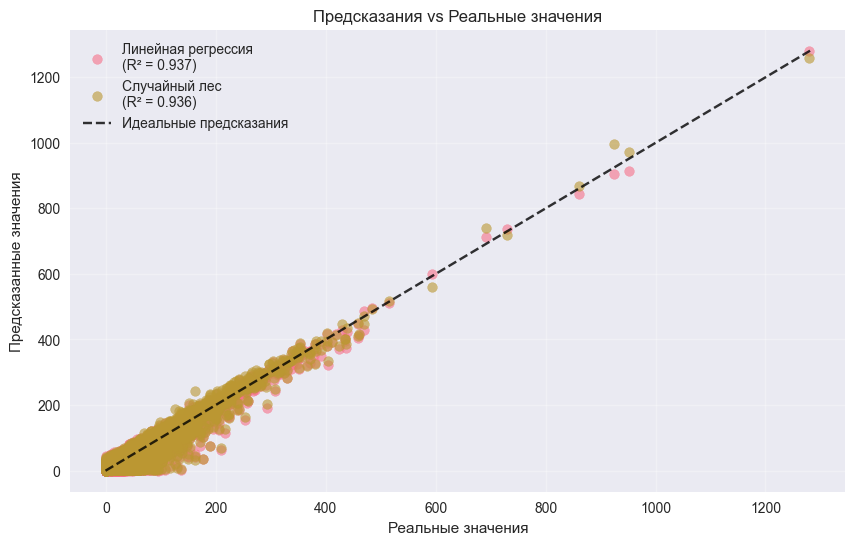

R² для линейной регрессии: 0.937
R² для случайного леса: 0.936
RMSE для линейной регрессии: 9.839 минут
RMSE для случайного леса: 9.973 минут


In [40]:
# Строим график предсказаний vs реальных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, lin_pred, alpha=0.6, label=f'Линейная регрессия\n(R² = {lin_r2:.3f})')
plt.scatter(y_test_reg, rf_pred, alpha=0.6, label=f'Случайный лес\n(R² = {rf_r2:.3f})')

# Добавляем идеальную линию
min_val = min(y_test_reg.min(), lin_pred.min(), rf_pred.min())
max_val = max(y_test_reg.max(), lin_pred.max(), rf_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Идеальные предсказания')

plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказания vs Реальные значения')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"R² для линейной регрессии: {lin_r2:.3f}")
print(f"R² для случайного леса: {rf_r2:.3f}")
print(f"RMSE для линейной регрессии: {lin_rmse:.3f} минут")
print(f"RMSE для случайного леса: {rf_rmse:.3f} минут")